Importing the required packages.

In [108]:
# @title Imports (run this cell)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from IPython import display
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

Creating DataFrames containing movies, users, and ratings

In [109]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [110]:
users.describe()

,age
count,943.000000
mean,34.051962
std,12.192740
min,7.000000
25%,25.000000
50%,31.000000
75%,43.000000
max,73.000000


In [111]:
users.describe(include=[np.object])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,0,M,student,55414
freq,1,670,196,9


 Information about the movies and their ratings.

In [112]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

In [113]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358491
257,Contact (1997),509,3.803536
99,Fargo (1996),508,4.155512
180,Return of the Jedi (1983),507,4.007890
293,Liar Liar (1997),485,3.156701
285,"English Patient, The (1996)",481,3.656965
287,Scream (1996),478,3.441423
0,Toy Story (1995),452,3.878319
299,Air Force One (1997),431,3.631090
120,Independence Day (ID4) (1996),429,3.438228


In [114]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491071
317,Schindler's List (1993),298,4.466443
168,"Wrong Trousers, The (1993)",118,4.466102
482,Casablanca (1942),243,4.456790
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761
63,"Shawshank Redemption, The (1994)",283,4.445230
602,Rear Window (1954),209,4.387560
11,"Usual Suspects, The (1995)",267,4.385768
49,Star Wars (1977),583,4.358491
177,12 Angry Men (1957),125,4.344000


the ratings DataFrame, which we group by user_id.

In [115]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

,user_id,movie_id
0,0,"[60, 188, 32, 159, 19, 201, 170, 264, 154, 116..."
1,1,"[291, 250, 49, 313, 296, 289, 311, 280, 12, 27..."
2,10,"[110, 557, 731, 226, 424, 739, 722, 37, 724, 1..."
3,100,"[828, 303, 595, 221, 470, 404, 280, 251, 281, ..."
4,101,"[767, 822, 69, 514, 523, 321, 624, 160, 447, 4..."


In [116]:
#@title CFModel helper class
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

We then create a function that generates an example batch, such that each example contains the following features:

movie_id: A tensor of strings of the movie ids that the user rated.
genre: A tensor of strings of the genres of those movies
year: A tensor of strings of the release year.

In [117]:
#@title Batch generation code (run this cell)
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

Loss function for softmax_model

In [118]:
def softmax_loss(user_embeddings, movie_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [119]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

Build a softmax model, train it, and inspect its embeddings.

In [120]:
# @title Solution

def build_softmax_model(ratings,rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = train_test_split(rated_movies,test_size = 0.1, random_state = 1)
  train_ratings, test_ratings = train_test_split(ratings,test_size = 0.1, random_state = 1)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")
    A_train = build_rating_sparse_tensor(train_ratings)
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], 35], stddev=1.))

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"user_id": U, "movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

 iteration 3000: train_loss=5.663930, test_loss=5.964527, test_precision_at_10=0.011411

({'test_loss': 5.964527, 'train_loss': 5.66393},
 {'test_precision_at_10': 0.01141086304565145})

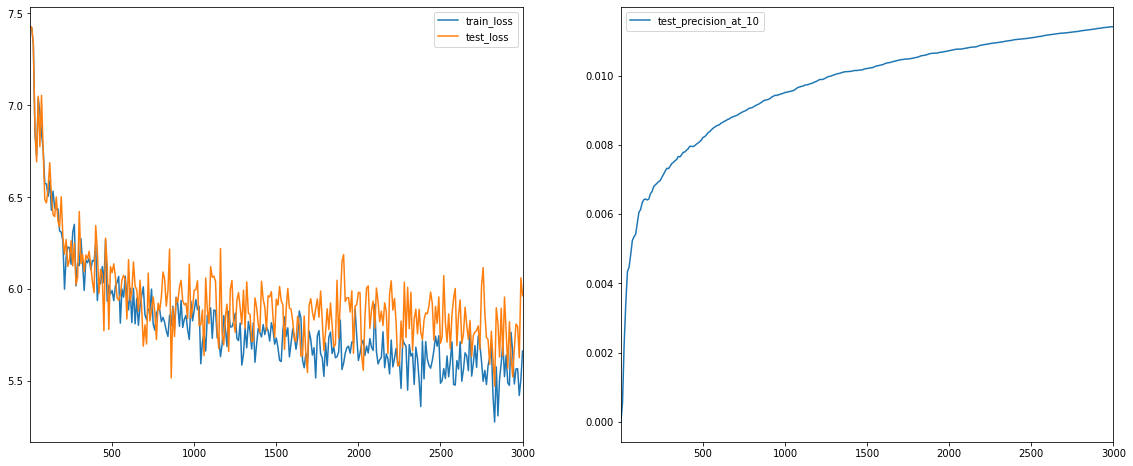

In [121]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      ratings,
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

Recommender

 function that computes the scores of the candidates

In [122]:
def compute_scores(query_embedding, item_embeddings, measure='dot'):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == 'cosine':
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.

In [123]:
def user_recommendations(model, user_id, measure='dot', exclude_rated=False, k=6):
  if user_id <= len(model.embeddings['user_id']):
    scores = compute_scores(
        model.embeddings["user_id"][user_id], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure='dot', k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

recommendations

Movie based

In [124]:
movie_neighbors(softmax_model, "Aladdin", 'dot')
movie_neighbors(softmax_model, "Aladdin", 'cosine')

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,24.595016,Aladdin (1992),Animation-Children-Comedy-Musical
0,22.427801,Toy Story (1995),Animation-Children-Comedy
173,19.839838,Raiders of the Lost Ark (1981),Action-Adventure
180,19.608521,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
14,19.442513,Mr. Holland's Opus (1995),Drama
81,19.259548,Jurassic Park (1993),Action-Adventure-Sci-Fi


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000000,Aladdin (1992),Animation-Children-Comedy-Musical
81,0.796025,Jurassic Park (1993),Action-Adventure-Sci-Fi
70,0.793956,"Lion King, The (1994)",Animation-Children-Musical
431,0.753364,Fantasia (1940),Animation-Children-Musical
202,0.752364,Unforgiven (1992),Western
587,0.751910,Beauty and the Beast (1991),Animation-Children-Musical


User based

In [125]:
user_recommendations(softmax_model, user_id=6, exclude_rated=True, k=10)

,dot score,movie_id,titles,genres
826,14.038827,826,Daylight (1996),Action-Adventure-Thriller
1046,13.997596,1046,Multiplicity (1996),Comedy
411,13.862173,411,"Very Brady Sequel, A (1996)",Comedy
405,13.692696,405,Thinner (1996),Horror-Thriller
121,12.751020,121,"Cable Guy, The (1996)",Comedy
104,12.670421,104,Sgt. Bilko (1996),Comedy
832,12.484359,832,Bulletproof (1996),Action
408,12.218915,408,Jack (1996),Comedy-Drama
368,12.195808,368,Black Sheep (1996),Comedy
1043,11.964200,1043,"Paper, The (1994)",Comedy-Drama
